# **Bioinformatics Project- Sarthak Mahapatra**




In this source code, I will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 1**, we will be performing Data Collection and Pre-Processing from the ChEMBL Database.

In **Part 2**, we will be performing Lipnski Descriptor Calculation

In **Part 3**, we will be calculating  Padel molecular descriptors that are essentially quantitative description of the compounds in the dataset. Finally, we will be preparing this into a dataset for subsequent model building in Part 4

In **Part 4**, we will be comparing several ML algorithms and feature reduction methods for build regression models of acetylcholinesterase inhibitors.

In **Part 5**, We will use the best model and make a sklearn pipeline which takes input as canonical smiles does feature extraction then PCA , regression and gives out IC50 values.Then we save this model as a pickle file to make a API using FAST API

---

### **Part 1**

Installing the ChEMBL web service package so that we can retrieve bioactivity data

In [ ]:
! pip install chembl_webresource_client

  Using cached chembl_webresource_client-0.10.9-py3-none-any.whl (55 kB)
ERROR: Could not find a version that satisfies the requirement requests-cache~=1.2 (from chembl_webresource_client) (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.2.0, 0.2.1, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.5.0, 0.5.1, 0.5.2, 0.6.0, 0.6.1, 0.6.2, 0.6.3, 0.6.4, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9.7, 0.9.8, 1.0.0a0, 1.0.0a1, 1.0.0a2, 1.0.0b0, 1.0.0b1, 1.0.0, 1.0.1, 1.1.0, 1.1.1)
ERROR: No matching distribution found for requests-cache~=1.2 (from chembl_webresource_client)


**Importing libraries**




In [ ]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Retreiving SARS coronavirus 3C-like proteinase in the form of IC$_{50}$ unit from CHEMBL database**

*    Search for our target organism-SARS Coronavirus
*    Retrieve bioactivity data for  our target protien for SARS coronavirus- SARS coronavirus 3C-like proteinase.
*    We will retrieve only bioactivity data of compounds targeted  for *coronavirus 3C-like proteinase* (CHEMBL3927) that are reported as IC$_{50}$ values in nM (nanomolar) unit.
*  Store the filter data in a pandas dataframe for further analysis



In [ ]:
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)


selected_target = targets[targets['pref_name']=='SARS coronavirus 3C-like proteinase'].target_chembl_id.iloc[0]
selected_target

activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df.head()


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0


**Data Preproceesing**


We will need the standard value and the canonical smiles and the  for our further analysis.
*   Handling missing values

We will need the standard value(IC50 values) and the canonical smiles and the  for our further analysis.
Drop the compunds which has null value in their **standard_value** or **canonincal_smilies** column.

* Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame

*  To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially    -log10(IC50).

We make a  custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [ ]:
df2 = df[df.canonical_smiles.notna()  | df.standard_value.notna()]
df2['standard_value']=df2['standard_value'].astype(float) # keeping the standard value as a numerical column
df2

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,None,None,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.6
129,None,None,12041508,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.1
130,None,None,12041509,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,11.5
131,None,None,12041510,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.7


Apparently, for this dataset there is no missing data

**Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value)**

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2[selection]
df3 # Our Final Dataframe

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0
...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0


<Axes: ylabel='Frequency'>

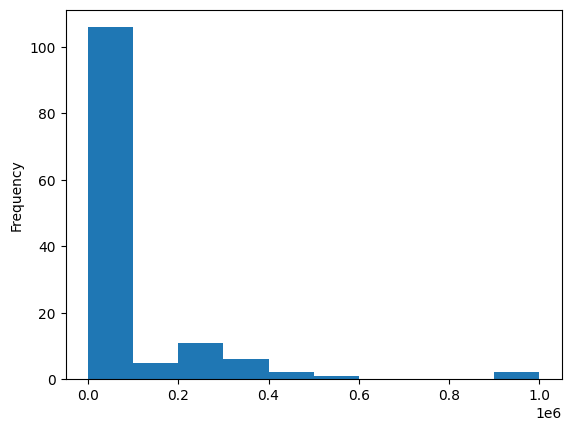

In [ ]:
df3.standard_value.plot(kind='hist') # highly right skewed

In [ ]:
def pIC50(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value',axis= 1)
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x= input.drop(['standard_value','standard_value_norm'],axis= 1)

    return x


In [ ]:
pIC50(pd.DataFrame([1130],columns=['standard_value']) ).iloc[0]

pIC50    5.946922
Name: 0, dtype: float64

In [ ]:
df3=pIC50(df3)

<ipython-input-58-5ffe38b25812>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input['standard_value_norm'] = norm
<ipython-input-58-5ffe38b25812>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input['pIC50'] = pIC50


In [ ]:
df3

,molecule_chembl_id,canonical_smiles,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],5.698970
...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,4.970616


### **Part 2**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-06-01 07:04:09--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   105MB/s    in 0.8s    

2024-06-01 07:04:10 (105 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1

**Calculate Lipinski descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

1. Molecular weight < 500 Dalton
2. Octanol-water partition coefficient (LogP) < 5
3. Hydrogen bond donors < 5
4. Hydrogen bond acceptors < 10

In [ ]:
!pip install rdkit-pypi -qqq


In [ ]:
#Importing libraries for calculting descriptors
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

df_lipinski = lipinski(df3.canonical_smiles)
#putting descriptors in my original dataframe
df = pd.concat([df3,df_lipinski], axis=1)

In [ ]:
df.head()

,molecule_chembl_id,canonical_smiles,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,5.026872,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,4.869666,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,4.882397,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],5.698970,338.344,3.53900,0.0,5.0


In [ ]:
df.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'pIC50', 'MW', 'LogP',
       'NumHDonors', 'NumHAcceptors'],
      dtype='object')

In [ ]:
df.head()

,molecule_chembl_id,canonical_smiles,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,5.026872,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,4.869666,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,4.882397,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],5.698970,338.344,3.53900,0.0,5.0


## **Part 3**

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2024-06-01 07:05:01--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2024-06-01 07:05:02--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.1’

padel.zip.1         100%[===================>]  24.57M   162MB/s    in 0.2s    

2024-06-01 07:05:02 (162 MB/s) - ‘padel.zip.1’ saved [25768637/25768637]

--2024-06-01 07:05:02--  https://gi

In [ ]:
! unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)


In [ ]:
! cat molecule.smi | head -5

Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21	CHEMBL187579
O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21	CHEMBL188487
O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21	CHEMBL185698
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21	CHEMBL426082
O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]	CHEMBL187717


In [ ]:
! bash padel.sh

Processing CHEMBL187579 in molecule.smi (1/133). 
Processing CHEMBL188487 in molecule.smi (2/133). 
Processing CHEMBL185698 in molecule.smi (3/133). Average speed: 2.21 s/mol.


In [ ]:
df_final_Padel = pd.read_csv('descriptors_output.csv') # all the Padel Descriptors

In [ ]:
df_final_Padel

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL187579,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL188487,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Removing all those PaDel descriptors that are constant or nearly constant or highly unbalanced

In [ ]:
df_final_Padel

constant_features = []
for column in df_final_Padel.columns:
    unique_values = df_final_Padel[column].unique()
    if len(unique_values) == 1:
        constant_features.append(column)
    elif max(df_final_Padel[column].value_counts()[1],df_final_Padel[column].value_counts()[0])/len(df_final_Padel[column])>=0.90:
      constant_features.append(column)


# Drop identified columns
df_final_Padel.drop(columns=constant_features, inplace=True)


In [ ]:
# Concatenting the Padel Descriptors into my original dataframe
df=pd.concat([df,df_final_Padel.drop(['Name'],axis=1)],axis=1)# Dropping name as it is same molecule_chembl_id
df

,molecule_chembl_id,canonical_smiles,pIC50,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP15,PubchemFP23,PubchemFP37,...,PubchemFP651,PubchemFP652,PubchemFP676,PubchemFP697,PubchemFP716,PubchemFP734,PubchemFP759,PubchemFP779,PubchemFP797,PubchemFP822
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,281.271,1.89262,0.0,5.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,5.026872,415.589,3.81320,0.0,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,4.869666,421.190,2.66050,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,4.882397,293.347,3.63080,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],5.698970,338.344,3.53900,0.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,4.974694,338.359,3.40102,0.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,4.995679,296.366,3.44330,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,4.939302,276.291,4.09564,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,4.970616,278.307,3.29102,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Part 4**

In [ ]:
df

,molecule_chembl_id,canonical_smiles,pIC50,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP15,PubchemFP23,PubchemFP37,...,PubchemFP651,PubchemFP652,PubchemFP676,PubchemFP697,PubchemFP716,PubchemFP734,PubchemFP759,PubchemFP779,PubchemFP797,PubchemFP822
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,281.271,1.89262,0.0,5.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,5.026872,415.589,3.81320,0.0,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,4.869666,421.190,2.66050,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,4.882397,293.347,3.63080,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],5.698970,338.344,3.53900,0.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,4.974694,338.359,3.40102,0.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,4.995679,296.366,3.44330,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,4.939302,276.291,4.09564,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,4.970616,278.307,3.29102,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dimensionalty Reduction

In [ ]:
feat=5

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA,FastICA

# Assuming df is your dataframe with features and the target variable 'standard_values'
np.random.seed(101) # For reporducability
X=df.drop(['molecule_chembl_id', 'canonical_smiles', 'pIC50'], axis=1)
y=df['pIC50']
# Feature Scaling
scaler = StandardScaler()
X= scaler.fit_transform(df.drop(['molecule_chembl_id', 'canonical_smiles', 'pIC50'], axis=1))
X=pd.DataFrame(X,columns=df.drop(['molecule_chembl_id', 'canonical_smiles', 'pIC50'], axis=1).columns)

# Initialize and fit PCA
pca = PCA(n_components=feat)  # Reduce to 5 components
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])
df_pca['IC50']=y

# Initialize and fit ICA
ica = FastICA(n_components=feat)  # Reduce to 5 components
X_ica = ica.fit_transform(X)

# Create a DataFrame from the transformed data
df_ica = pd.DataFrame(data=X_ica, columns=[f'ICA_{i+1}' for i in range(X_ica.shape[1])])
df_ica['IC50']=y


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

RFE Feature Selection

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
np.random.seed(101)
X=df.drop(['molecule_chembl_id', 'canonical_smiles', 'pIC50'], axis=1)
y=df['pIC50']
# Initialize StandardScaler
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

# Initialize three different feature selection methods
feature_selection_methods = {
    'Recursive feature elimination with estimator as Linear Regression': RFE(estimator=LinearRegression(), n_features_to_select=feat),  # Recursive Feature Elimination with Linear Regression
    'Recursive feature elimination with estimator as Random Forest Regression': RFE(estimator=RandomForestRegressor(), n_features_to_select=feat)  # Recursive Feature Elimination with Random Forest
}

# Results dictionary to store selected features for each method
selected_features = {}

# Iterate over each feature selection method
for method_name, method in feature_selection_methods.items():
    # Fit feature selection method to scaled data
    method.fit(X_scaled, y)

    # Store selected features
    selected_features[method_name] = X.columns[method.get_support()]

# Create DataFrames from selected features for each method
selected_features_dfs = {}
for method_name, features in selected_features.items():
    selected_features_dfs[method_name] = X[features]

# Display the selected features DataFrames for each method
for method_name, df_ in selected_features_dfs.items():
    print(f"Selected Features for {method_name}:")
    print(list(df_.columns))


In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
i=0
for method_name, df_ in selected_features_dfs.items():
    ax[i].set_title(f"Corr Matrix after {method_name}:")
    df_.loc[:,'IC50']=y
    sns.heatmap(df_.corr(),annot=True,cmap='coolwarm',ax=ax[i])
    i=i+1

In [ ]:
# Create copies of selected features DataFrames to preserve the original DataFrames
selected_features_dfs_cleaned = selected_features_dfs.copy()

# Iterate through each selected features DataFrame
for method_name, df_ in selected_features_dfs_cleaned.items():
    # Calculate correlation matrix
    corr_matrix = df_.corr().abs()

    # Create a mask to identify highly correlated features
    upper_triangle_mask = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find pairs of highly correlated features
    highly_correlated_features = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > 0.7)]

    # Drop one of the features from each pair
    df_.drop(highly_correlated_features, axis=1, inplace=True)

# Display the cleaned selected features DataFrames for each method
for method_name, df_ in selected_features_dfs_cleaned.items():
    print(f"Cleaned Selected Features for {method_name}:")
    print(df_.columns)


In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
i=0
for method_name, df_ in selected_features_dfs_cleaned.items():
    ax[i].set_title(f"Corr Matrix after {method_name}:")
    df_.loc[:,'IC50']=y
    sns.heatmap(df_.corr(),annot=True,cmap='coolwarm',ax=ax[i])
    i=i+1

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.heatmap(df_ica.corr(),annot=True,cmap='coolwarm',ax=ax[0],)
sns.heatmap(df_pca.corr(),annot=True,cmap='coolwarm',ax=ax[1])


Regression Modelling

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
np.random.seed(101)
# Initialize the models with hyperparameter grids for tuning
models = {
    'Linear Regression': (LinearRegression(), {}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 10, 20,30,40,50]}),
    'Random Forest': (RandomForestRegressor(), {'max_depth': [None, 10, 20,30,40,50], 'n_estimators': range(10,201,10)}),
    'XGBoost': (XGBRegressor(), {'max_depth': range(10,51,10), 'n_estimators': range(10,201,200)})
}

# Results dictionary to store RMSE and R2 score for each model
results = {'Model': [], 'Dimensionality Reduction': [], 'RMSE': [], 'R2 Score': [],'Best Parameters':[]}

# Function to evaluate models and store results
def evaluate_model(model, params, X_train, X_test, y_train, y_test, dim_reduction):
    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set
    predictions = best_model.predict(X_test)
    best_params=grid_search.best_params_
    # Calculate RMSE and R2 score
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    return rmse, r2,best_params

# Iterate over each DataFrame
for dim_reduction, df_ in {'PCA': df_pca, 'ICA': df_ica}.items():
    # Split into features (X) and target variable (y)
    X = df_.drop(columns=['IC50'])
    y = df_['IC50']

    # Split into training and testing sets (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    # Iterate over each model
    for model_name, (model, params) in models.items():
        # Evaluate the model and store results
        rmse, r2, best_params = evaluate_model(model, params, X_train, X_test, y_train, y_test, dim_reduction)
        results['Model'].append(model_name)
        results['Dimensionality Reduction'].append(dim_reduction)
        results['RMSE'].append(rmse)
        results['R2 Score'].append(r2)
        results['Best Parameters'].append(best_params)

# Create DataFrame from results dictionary
results_df_1 = pd.DataFrame(results)

# Display the results
results_df_1.round(2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have a DataFrame named 'df' with your target variable in 'y'
np.random.seed(101)
# Function to evaluate models and store results
def evaluate_model(model, X_train, X_test, y_train, y_test, method_name, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Calculate RMSE and R2 score
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = np.round(r2_score(y_test, predictions),2)

    # Store results
    results['Feature Selection Method'].append(method_name)
    results['Model'].append(model_name)
    results['RMSE'].append(rmse)
    results['R2 Score'].append(r2)




# Results dictionary to store results
results = {
    'Feature Selection Method': [],
    'Model': [],
    'RMSE': [],
    'R2 Score': [],
    'Best Parameters': []
}

# Models to evaluate
models = {
    'Linear Regression': (LinearRegression(), {}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 10, 20,30,40,50]}),
    'Random Forest': (RandomForestRegressor(), {'max_depth': [None, 10, 20,30,40,50], 'n_estimators': range(10,201,10)}),
    'XGBoost': (XGBRegressor(), {'max_depth': range(1,51,10), 'n_estimators': range(10,201,200)})
}

# Iterate over each model
for model_name, (model, param_grid) in models.items():
    # Iterate over each cleaned selected features DataFrame
    for method_name, df_ in selected_features_dfs_cleaned.items():
        # Get selected features for the current method
        X_selected = df_
        X=df_.drop('IC50',axis=1)
        y=df_['IC50']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
        # Split selected features into training and testing sets


        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train, y_train)

        # Evaluate the model
        evaluate_model(grid_search.best_estimator_, X_train, X_test, y_train, y_test, method_name, model_name)
        if model_name=='Linear Regression':
           results['Best Parameters'].append({})
        else:
          results['Best Parameters'].append(str(grid_search.best_params_))


# Create DataFrame from results dictionary
results_df = pd.DataFrame(results)

# Display the results
results_df.round(2)


In [ ]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)
display(results_df.round(2))

# Part 5

In [ ]:
import subprocess
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
def feature_extractor(smiles):
    ### 1. Lipinski Descriptors
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = []
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = [desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors]
        baseData.append(row)

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    lipinkski = pd.DataFrame(data=baseData,columns=columnNames)

    ## 2. Padel Descriptors
    df_s = pd.DataFrame(smiles)
    df_s.to_csv('molecule.smi', sep='\t', index=False, header=False)
    # Run the bash script
    result = subprocess.run(['bash', 'padel.sh'], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    Padel=pd.read_csv('descriptors_output.csv')
    Padel.drop('Name',axis=1,inplace=True)
    joined_df = pd.concat([Padel, lipinkski], axis=1)
    return joined_df.values



In [ ]:
df.canonical_smiles[0:1].tolist()

In [ ]:
x=feature_extractor(df.canonical_smiles[0:1].tolist())

In [ ]:
x.shape

(1, 885)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR


class SmilesFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return feature_extractor(X)


# Create the pipeline
pipeline = Pipeline([
    ('feature_extractor', SmilesFeatureExtractor()),  # Convert SMILES to features
    ('scaler', StandardScaler()),                     # Scale features
    ('pca', PCA(n_components=5)),                     # Apply PCA
    ('regression', SVR(C=1))                         # Pre-trained SVR model
])

# Fit the pipeline with training data
smiles_train = df['canonical_smiles'].tolist()
y_train = df['pIC50']
pipeline.fit(smiles_train, y_train)


Pipeline(steps=[('feature_extractor', SmilesFeatureExtractor()),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('regression', SVR(C=1))])

In [ ]:

prediction=pipeline.predict(df['canonical_smiles'].tolist()[2:3])

In [ ]:
prediction[0]

4.860165805747915

In [ ]:
df.head()

In [ ]:
drug_data = [
    {
        "name": "Remdesivir",
        "smiles": "CC[C@H]1C(=O)N(C[C@H](C1O)n2cnc3c(N)ncnc32)C(=O)CC(CC(C)C)N",
        "IC50": pd.DataFrame([1760],columns=['standard_value'])  # nM
    },
    {
        "name": "Chloroquine",
        "smiles": "CCNC(CCC1=CC=NC2=C1C=CC=C2)C(C)C",
        "IC50": pd.DataFrame([1130],columns=['standard_value'])  # nM
    },
    {
        "name": "Hydroxychloroquine",
        "smiles": "CCN(CC)CCCC(C1=CC2=C(C=C1)NC=N2)O",
        "IC50": pd.DataFrame([720],columns=['standard_value'])   # nM
    },
    {
        "name": "Lopinavir",
        "smiles": "CC(C)C1=CC=C(C=C1)C2C(CC(=O)NC2C(=O)N[C@H](CC3=CC=CC=C3)C(=O)N4CCCC4)OC(C)(C)C",
        "IC50": pd.DataFrame([26630],columns=['standard_value'])   # nM
    },
    {
        "name": "Favipiravir",
        "smiles": "CC1=CN(C(=O)N=C1)C2=NC=C(C=C2)N",
        "IC50": pd.DataFrame([61880],columns=['standard_value'])
    },
    {
        "name": "Ritonavir",
        "smiles": "CC(C)(C1=CC=C(C=C1)C2C(CC(=O)NC2C(=O)N[C@H](CC3=CC=CC=C3)C(=O)N4CCCC4)OC(C)(C)C)N5CCN(CC5)C",
        "IC50": pd.DataFrame([11600],columns=['standard_value']) # nM
    }
]

for drug in drug_data:
  print('Drug Name',drug['name'])
  pic50=pIC50(pd.DataFrame(drug['IC50'],columns=['standard_value'])).iloc[0][0]
  print(f'IC50 value in negative log : {pic50}')
  pred=pipeline.predict([drug['smiles']])
  print(f'Regression model value : {pred[0]}')



Drug Name Remdesivir
IC50 value in negative log : 5.7544873321858505
Regression model value : 4.931702490959665
Drug Name Chloroquine
IC50 value in negative log : 5.94692155651658
Regression model value : 4.690803692326898
Drug Name Hydroxychloroquine
IC50 value in negative log : 6.142667503568731
Regression model value : 3.9717928566746057
Drug Name Lopinavir
IC50 value in negative log : 4.574628833561059
Regression model value : 4.443427625535238
Drug Name Favipiravir
IC50 value in negative log : 4.2084496949726695
Regression model value : 4.7665268507308465
Drug Name Ritonavir
IC50 value in negative log : 4.935542010773082
Regression model value : 4.41691368620244


In [ ]:
import pickle
pickle_out = open("regression_model.pkl","wb")
pickle.dump(pipeline, pickle_out)
pickle_out.close()